# Tabular Playground Series - Aug 2022 - Makiu

This notebook presents my submission to the 2022 August edition of the Kaggle competition *Tabular Playground Series*. My goal here is to test myself with a very basic project, applying the knowledge I got in my data science master's degree, before moving on to more challenging competitions where I will focus on learning new stuff on my own. My approach will be simple, applying a brief EDA and preprocessing and then using xgboost to quickly find a good model. 

## EDA

As many machine learning projects, we will start with an initial exploratoy data analysis (EDA), to get a feel of the available data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

As the name of the competition implies, this project involves tabular data, which is clearly the easiest type. So, first things first, we import the training data, which is included in a single *csv* file.

In [3]:
data = pd.read_csv('data/train.csv')

Let's start checking the basic information of this dataset.

In [4]:
data.shape

(26570, 26)

In [5]:
data.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

In [6]:
data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [7]:
data.dtypes

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

In [8]:
data.product_code.unique()

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

We've got 26 columns including ID, true label and 24 features. Among these features we find *product_code*, which is a string representing a letter (A-E); *loading*, which is a float number; four *attributes*, which are strings and integers; and eighteen *measurements*, which are also floats. The true label, named *failure*, is binary.

Before proceeding with the analysis we will think some hypothesis and ask ourselves questions that we can potentially solve with this EDA. With this step we will acquire goals that will loosely guide the rest of the EDA.

* The product code, can it be deduced from the attributes or measurements?
* Is there any underlying relationship between the attributes?
* We have 18 measurements. Do they all bring relevant information regarding the failure rate? Can we summarize them?
* The *loading* variable seems especially important given its meaning (amount of fluid absorbed in the experiment). Can we deduce any relationship with *failure*?



Starting with *attribute_0* and *attribute_1*, which along with *product_code* are the only non-numeric features, we find that the possible values they take are very limited (2 and 3, respectively). In the case of *attribute_0* we find some imbalance (about 4:1), while in the case of *attribute_1* it is relatively balanced.

0.24624765478424016


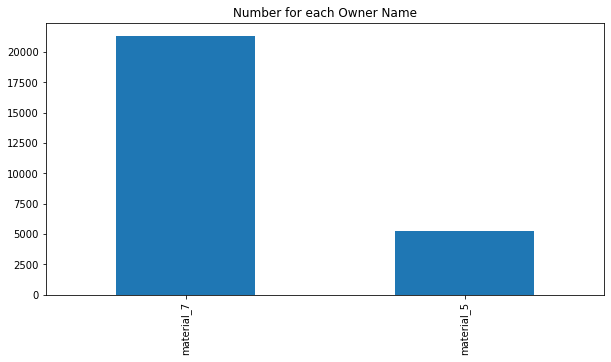

In [9]:
data.attribute_0.value_counts().plot(kind='bar', figsize=(10,5), title="Number for each Owner Name")
print(data.attribute_0.value_counts()[1] / data.attribute_0.value_counts()[0])

<AxesSubplot:title={'center':'Number for each Owner Name'}>

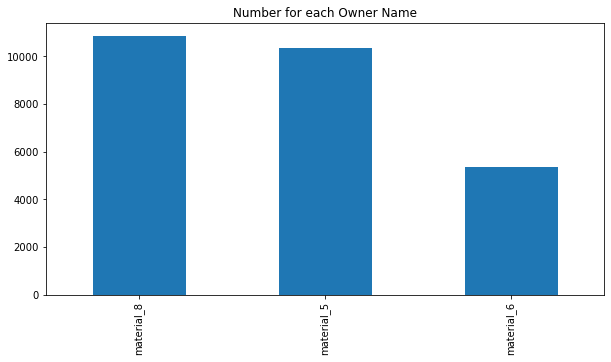

In [10]:
data.attribute_1.value_counts().plot(kind='bar', figsize=(10,5), title="Number for each Owner Name")

The fact that the ranges of possible values are quite narrow means that they can be easily encoded in different ways. Encoding with numbers may be problematic, since this features represent types of materials, which cannot be accurately described with just a single number. Instead, one possible approach would be one-hot encoding, which would exploit the fact previously mentioned. This way we avoid the problem of the misleading meaning of the numeric encoding and also would be prepared to predict instances with previously unseen values (e.g. *material_42*).

Examining the integer columns, we see that all of them except *id* can be safely downcasted to int8 to save up some memory.

In [11]:
int_cols = data.select_dtypes('integer').columns

data[int_cols].describe()

,id,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,failure
count,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000
mean,13284.500000,6.754046,7.240459,7.415883,8.232518,6.256568,0.212608
std,7670.242662,1.471852,1.456493,4.116690,4.199401,3.309109,0.409160
min,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,6642.250000,6.000000,6.000000,4.000000,5.000000,4.000000,0.000000
50%,13284.500000,6.000000,8.000000,7.000000,8.000000,6.000000,0.000000
75%,19926.750000,8.000000,8.000000,10.000000,11.000000,8.000000,0.000000
max,26569.000000,9.000000,9.000000,29.000000,29.000000,24.000000,1.000000


In [12]:
data[int_cols[1:]] = data[int_cols[1:]].apply(pd.to_numeric, downcast='integer')
data.dtypes

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2          int8
attribute_3          int8
measurement_0        int8
measurement_1        int8
measurement_2        int8
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure              int8
dtype: object

Now we'll study the distribution of the values in each column. Let's start with numeric columns:

In [13]:
data.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,25633.000000,25522.000000,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,11.716624,19.024714,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,1.000836,1.008591,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,7.968000,15.217000,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,11.045000,18.340250,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,11.712000,19.021000,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,12.391000,19.708000,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,15.419000,23.807000,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


Firstly, in the integer columns we see that the values of *attribute_2* and *attribute_3* are contained in a very narrow range with only five possible values. The rest of the integer columns show a wider range (>20). Attributes 2 and 3 could represent categorical attributes encoded with numbers, or they could simply be numerical attributes that were measured with integers. Below we show the histograms of the integer columns:

array([[<AxesSubplot:title={'center':'attribute_2'}>,
        <AxesSubplot:title={'center':'attribute_3'}>,
        <AxesSubplot:title={'center':'measurement_0'}>,
        <AxesSubplot:title={'center':'measurement_1'}>,
        <AxesSubplot:title={'center':'measurement_2'}>]], dtype=object)

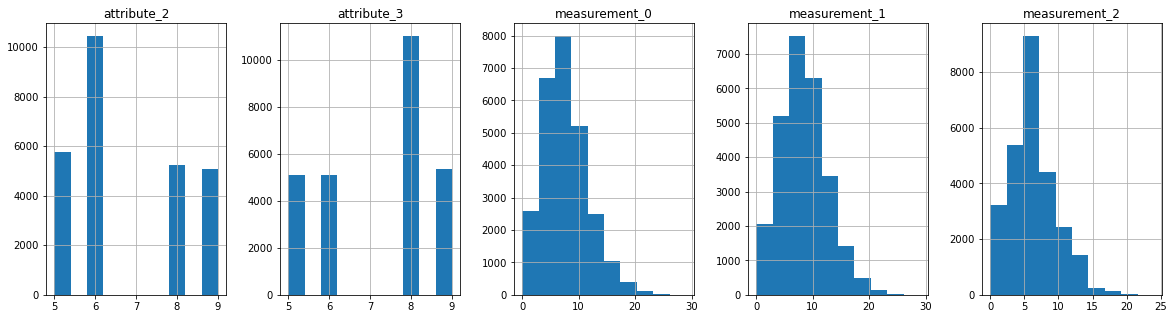

In [14]:
data[int_cols[1:-1]].hist(layout=(1,5), figsize=(20,5))

In *attribute_2* and *attribute_3* we see that the frequency of the values are quite similar except the value 7, which is never present, and an adjacent number (6 or 8) which contains roughly twice the amount of instances. The origin of this may be in the meaning of these attributes or in the way they were obtained (for example, if they were continuous attributes and were previously rounded up or down). We don't have enough information to guess one thing or the other. However, we should check the contingency table of these two variables since they show a similar behaviour:

In [15]:
pd.crosstab(index=data.attribute_2, columns=data.attribute_3)

attribute_3,5,6,8,9
attribute_2,,,,
5,0,0,5765,0
6,0,5112,0,5343
8,0,0,5250,0
9,5100,0,0,0


We see a clear relationship between the two. This relationship is not a one-to-one link like we could have expected, but still informs us that all the instances in the training set can be grouped in five groups based on these two attributes. This conclusion rings a bell... One of the available variables is *product_code*, whose possible values are the letters A to E. If we include this variable into the previous contingency table we find that the five codes fit neatly into the five possible pairings of attributes 2 and 3.

In [16]:
pd.crosstab(index=data.attribute_2, columns=[data.attribute_3, data.product_code])

attribute_3      5     6     8           9
product_code     A     D     B     C     E
attribute_2                               
5                0     0     0  5765     0
6                0  5112     0     0  5343
8                0     0  5250     0     0
9             5100     0     0     0     0

In other words, we can deduce the *product_code* given the values of attributes 2 and 3. Since we have redundant data, we face the choice of removing *product_code* or removing both *attribute_2* and *attribute_3*. The first option would allow us to keep the numerical meanings included in the attributes (e.g. the distance between 5 and 8 is the triple of 5 and 6), while the second option is more efficient (we remove one more variable). Since this dataset is not especially big we have no pressure to remove as much as possible, so we will choose the first option (dropping *product_code*).

In [17]:
data.drop(columns='product_code', inplace=True)

Back to the histograms of the integer variables, we see that the remaining three variables, which are all *measurements*, show smooth profiles. We will study the possible dependencies of the variables later along with the rest of the *measurements*.

Moving onto the histograms of the continuous features, we see that all of them show unimodal profiles with varying degrees of skewness.

array([[<AxesSubplot:title={'center':'measurement_0'}>,
        <AxesSubplot:title={'center':'measurement_1'}>,
        <AxesSubplot:title={'center':'measurement_2'}>,
        <AxesSubplot:title={'center':'measurement_3'}>,
        <AxesSubplot:title={'center':'measurement_4'}>,
        <AxesSubplot:title={'center':'measurement_5'}>],
       [<AxesSubplot:title={'center':'measurement_6'}>,
        <AxesSubplot:title={'center':'measurement_7'}>,
        <AxesSubplot:title={'center':'measurement_8'}>,
        <AxesSubplot:title={'center':'measurement_9'}>,
        <AxesSubplot:title={'center':'measurement_10'}>,
        <AxesSubplot:title={'center':'measurement_11'}>],
       [<AxesSubplot:title={'center':'measurement_12'}>,
        <AxesSubplot:title={'center':'measurement_13'}>,
        <AxesSubplot:title={'center':'measurement_14'}>,
        <AxesSubplot:title={'center':'measurement_15'}>,
        <AxesSubplot:title={'center':'measurement_16'}>,
        <AxesSubplot:title={'center':'m

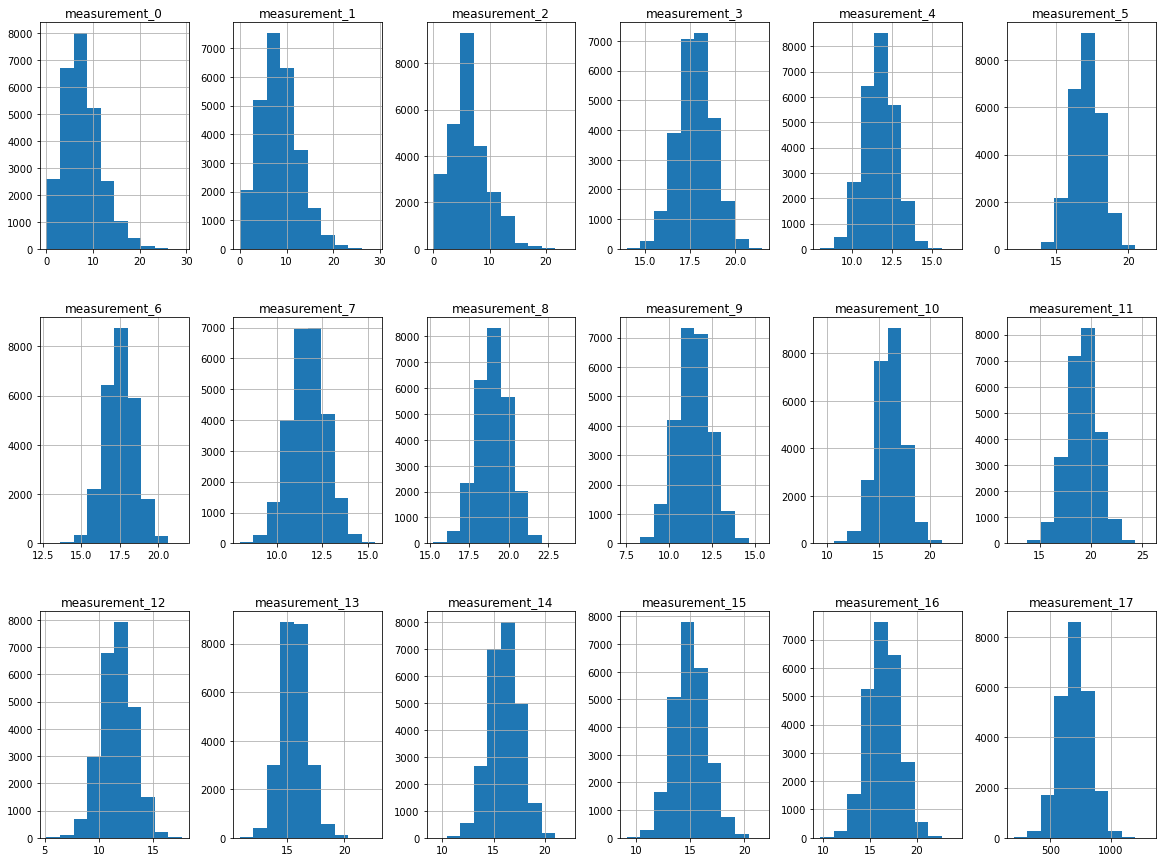

In [18]:
data.filter(regex='^measurement').hist(layout=(3,6), figsize=(20,15))

Next we will study the relationships between all the measurements. We can accomplish that with the following correlogram:

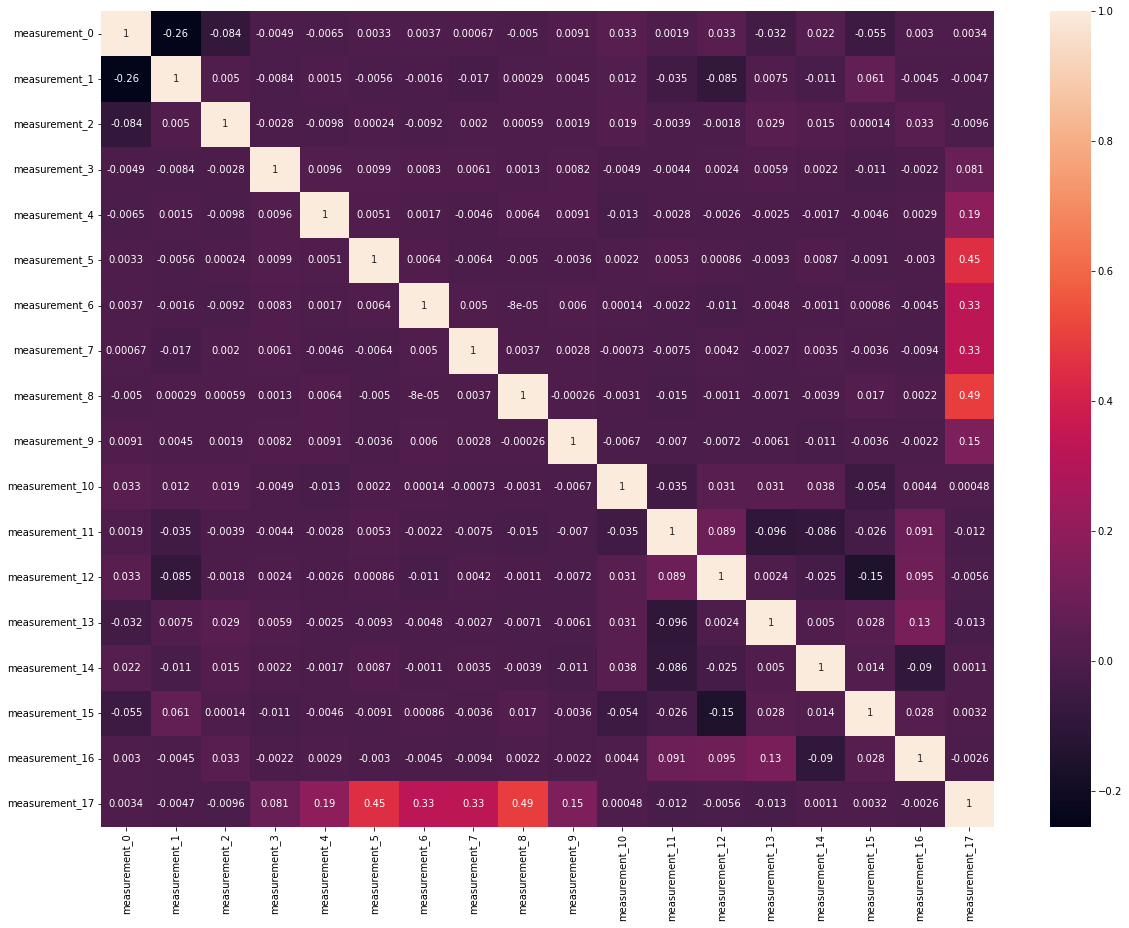

In [19]:
corrMatrix = data.filter(regex='^measurement').corr()
plt.subplots(figsize=(20, 15))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Most pairings result in correlations close to zero, suggesting no statistical relationships. The exception to this is *measurement_17* in combination with measurements 5 to 8 (especially these two), with correlations between 0.3 and 0.5. These values are not exceptionally high but point us to a possible dependency between these measurements. Based on this finding we can conclude that *measurement_17* is one of the most relevant of the group, and we can consider reducing the number of variables, by directly removing some of them or by any dimensionality reduction technique.

Now we will move onto the *loading* variable. In the following plot we show the histogram of this variable grouping by the target label, *failure*. We obtain a smooth, unimodal profile in both cases. The peaks (modes) are slightly shifted, with label 1 being higher. The dashed lines indicate the means of both groups, showing again the shift between both of them. If we assume that a value of 1 in *failure* denotes that the product failed, this would mean that products that absorbed a higher quantity of fluid were more likely to fail. In any case, this difference alone is not enough to predict the label. Otherwise we would be able to see two peaks in the whole histogram. In conclusion, *loading* does not provide enough information to predict the label but it may still contain valuable information for our task.

failure
0    125.205495
1    137.511973
Name: loading, dtype: float64


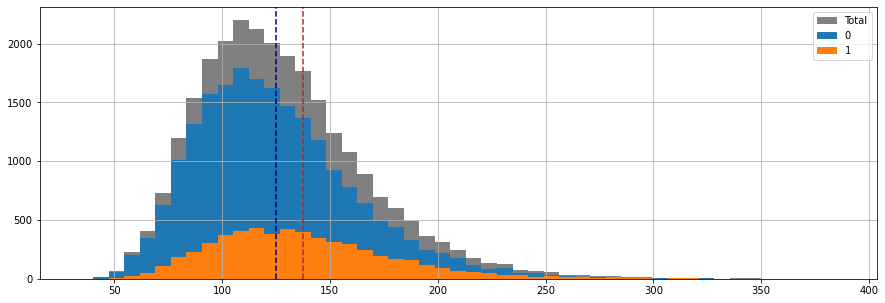

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
bins = np.linspace(data.loading.min(), data.loading.max(), 50)
means = data.groupby(by='failure').loading.mean()
print(means)

data.loading.hist(ax=ax, bins=bins, figsize=(15,5), label='Total', color='gray')
data.groupby(by='failure').loading.hist(ax=ax, bins=bins, figsize=(15,5), legend=True)
ax.axvline(x=means[0], color='navy', linestyle='--')
ax.axvline(x=means[1], color='brown', linestyle='--')

The previous histogram also shows that the number of instances with the label 0 is considerably higher than the number of instances with label 1. The true proportion in this dataset is close to 4:1, or more exactly a ratio of 0.27. This indicates that while there is some imbalance between the two classes, we do not have an urgent need to employ data imbalance techniques.

In [21]:
print(data.failure.value_counts())
print('Ratio: ', data.failure.value_counts()[1] / data.failure.value_counts()[0])

0    20921
1     5649
Name: failure, dtype: int64
Ratio:  0.27001577362458773


After analysing each feature, we will wrap up the EDA checking the presence of missing values.

In [22]:
data.isna().sum()

id                   0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

We find many missing values, especially in many of the *measurement* features. The feature with the most missing values is *measurement_17*, with close to 10% of values missing.

To sum up, after exploring the available data we reached the following conclusions:
* We have 25 features, of which we can directly remove 1 (*product_code*) and potentially more (dependencies of *measurement_17*).
* *product_code* can be inferred from *attribute_2* and *attribute_3*, so it is redundant.
* *attribute_0* and *attribute_1*, the remaining string features, can be easily encoded (e.g. one-hot encoding).
* *measurement_n* features are essentially uncorrelated, with the exception of *measurement_17* along with *measurement_5* to *8*. Therefore we can consider reducing the number of *measurement*.
* *loading* could be useful to predict *failure*.
* The dataset includes missing values, mainly in the *measurement* variables.

## Preprocessing

The very first step after the exploratory analysis is the partitioning, with the traditional 80/20 train-test split.

In [23]:
data_shuffled = data.sample(frac=1).reset_index(drop=True)
train_X = data_shuffled.iloc[:int(len(data_shuffled) * 0.8),:-1]
train_y = data_shuffled.iloc[:int(len(data_shuffled) * 0.8),-1]
test_X = data_shuffled.iloc[int(len(data_shuffled) * 0.8):,:-1]
test_y = data_shuffled.iloc[int(len(data_shuffled) * 0.8):,-1]

Next we would deal with the missing values. In our case it will not be necessary since we will later use xgboost to find our model. By default, xgboost supports missing values learning default branch directions for these missing values. So, we will skip the imputation phase to avoid the small biases it introduces. However, we will perform a simple imputation technique since the method that we will use for feature extraction does conflict with missing values. This technique is simply filling the missing values with the median values for each feature. We can directly apply this because all the features that present missing values in this dataset are numeric.

In [24]:
from sklearn.impute import SimpleImputer

def median_imputation(df, train):
    
    df_num = df.select_dtypes('number')
    df_not_num = df.select_dtypes('object')

    train_num = train.loc[:, df_num.columns]

    imputer = SimpleImputer(strategy='median')
    imputer.fit(train_num)
    df_num_imp = imputer.transform(df_num)
    df_num_imp = pd.DataFrame(df_num_imp, columns=df_num.columns.values)

    df_imp = pd.concat([df_num_imp, df_not_num], axis=1)
    df_imp = df_imp.loc[:,df.columns]

    return df_imp

train_X_imp = median_imputation(df=train_X, train=train_X)

After applying this function we can quickly test if there is any missing values remaining:

In [25]:
(train_X_imp.isna().sum() == True).any()

False

Now we will perform feature selection. We have already removed *product_code*, whose information was already present in *attribute_2* and *attribute_3*. We also considered removing either *measurement_17* or the group or measurements related to it. In our case we will choose neither option, and instead we will directly apply a feature selection technique called Boruta.

Boruta is an extension of the widely used method of using a model, such as a random forest, to estimate the importance of each feature and selecting features based on that importance score. The key of Boruta is to create *shadow features* which serve as a reference to keep or drop the original features. These *shadow features* are created as permutations of the values of each original feature.

In [29]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 5
)

boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 250
)

train_X_num = train_X_imp.select_dtypes('number')

boruta.fit(np.array(train_X_num), np.array(train_y))

selected_features = train_X_num.columns[boruta.support_].to_list()
tentative_features = train_X_num.columns[boruta.support_weak_].to_list()
print('features to keep:', selected_features)
print('features to tentatively keep:', tentative_features)

features to keep: ['loading']
features to tentatively keep: []


In [30]:
selected_features = ['loading','measurement_5','measurement_17']

Since the *shadow features* are generated randomly, the process is applied several times, where each of these runs classifies each feature as useful or not useful. For each feature we count the number of runs where it was useful and then based on this number we decide to keep it (if it was useful in most of the runs), drop it (if it was not useful in most of the runs) or tentatively keep it (if it is somewhere in between). To apply this criteria we assume that the number of runs where a feature is useful follows a binomial distribution, and selecting a threshold for the tails we can mathematically represent each of the three possible outcomes.

In our case, we will use a random forest regressor as our main model, since most of the features are numeric. This means that it will not be able to analyse *attribute_0* and *attribute_1*, so they will skip this step and be kept for the prediction model. After running this model 250 times, we find that out of the 21 numeric features (excluding *id*, which obviously will not be helpful for prediction) only four features are relevant: *loading*, *measurement_5* and *measurement_17*. All three of them appeared in the EDA: *loading* caught our attention from the beginning, and *measurement_5* and *measurement_17* are part of the only group of features that showed correlation.

To sum up, after applying Boruta, the resulting features that we will use for the prediction model are the following: *loading*, *attribute_0*, *attribute_1*, *measurement_5* and *measurement_17*.



Lastly, the implementation of xgboost we will use requires numerical features, so we need to either discard the categorical features (*attribute_0*, *attribute_1*) or transform them. In our case we will choose the second option, transforming *material_n* into the number *n*.

In [31]:
def cat_to_num(df):
    df.replace({'attribute_0': 'material_', 'attribute_1': 'material_'}, {'attribute_0': '', 'attribute_1': ''}, regex=True, inplace=True)
    return df.astype({'attribute_0': 'int32', 'attribute_1': 'int32'})

train_X_sel = train_X[['attribute_0','attribute_1']+selected_features+tentative_features].copy()
train_X_sel_num = cat_to_num(train_X_sel)

## Training

In this section we will deal with the training of a model with xgboost. For that we will focus on the hyperparameter optimization phase, with the following strategy:

* We focus on ROC AUC as the evaluation metric, since it's the metric used on Kaggle, and 5-fold cross validation.
* We establish a baseline with *num_parallel_tree*=3, *subsample*=0.7 and 5 boosting rounds.
* We start by optimizing *min_child_weight* and then *max_depth* for regularization.
* Then we obtimize *num_parallel_tree*, which essentially makes this a boosted random forest.
* We find the optimum for *eta*, also to reduce overfitting, and finally *subsample* to find the best value.
* Finally, we train the model with the selected values, using early stop to find the best number of boosting rounds.

Firsly, we train a reference model:

In [32]:
import xgboost as xgb

dtrain_X = xgb.DMatrix(train_X_sel_num, label=train_y)

params = {'subsample':0.7, 'num_parallel_tree':3, 'objective':'binary:logistic', 'eval_metric':'auc', 'seed':42}
xgb.cv(params, dtrain_X, num_boost_round=5, nfold=5, metrics=('error','auc'), seed=42)

c:\Users\gabri\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\gabri\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,train-error-mean,train-error-std,train-auc-mean,train-auc-std,test-error-mean,test-error-std,test-auc-mean,test-auc-std
0,0.206459,0.001071,0.617084,0.003566,0.210670,0.003618,0.572224,0.007268
1,0.207236,0.000963,0.635244,0.003217,0.209165,0.003887,0.572673,0.006717
2,0.207165,0.000852,0.645111,0.003181,0.209024,0.003924,0.573551,0.008290
3,0.207224,0.000746,0.653942,0.003147,0.208929,0.003645,0.575367,0.007945
4,0.207271,0.000848,0.662907,0.002368,0.208883,0.003886,0.574704,0.009385


With this function we will be able to apply each step of the HPO:

In [26]:
def fit(x, params, target):
    params[target] = x[0]
    xgb_cv = xgb.cv(dtrain=dtrain_X, params=params, nfold=5, metrics='auc', seed=42)
    return xgb_cv[-1:].values[0]

Now we start optimizing each parameter. First, *min_child_weight*:

Text(0, 0.5, 'AUC mean')

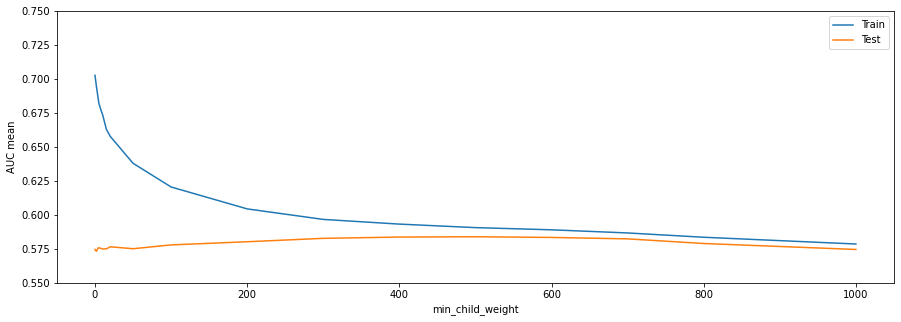

In [36]:
params = {'objective':'binary:logistic',
          'num_parallel_tree':3,
          'eval_metric':'auc',
          'subsample':0.7,
          'seed':42}

param_grid = pd.DataFrame({'min_child_weight':[0,1,2,4,5,8,10,15,20,50,100,200,300,400,500,600,700,800,1000]})
param_grid[['train-auc-mean','train-auc-std','test-auc-mean','test-auc-std']] = param_grid.apply(fit,axis=1,result_type='expand',params=params, target='min_child_weight')

fig, ax = plt.subplots(figsize=(15,5))
param_grid.plot(x='min_child_weight',y='train-auc-mean', ax=ax, label='Train')
param_grid.plot(x='min_child_weight',y='test-auc-mean', ax=ax, label='Test')
ax.set_ylim(0.55,0.75)
ax.set_ylabel('AUC mean')

The first couple hundreds deal effectively with overfitting. The difference between train and test remains constant starting at approximately 500. Therefore, this will be the value we select.

Next, *max_depth*:

Text(0, 0.5, 'AUC mean')

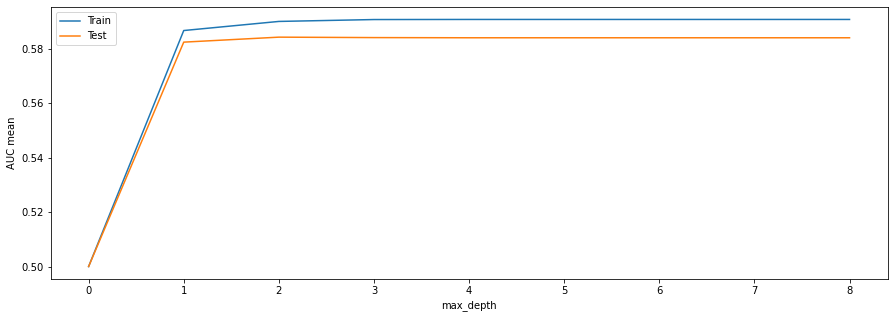

In [37]:
params = {'objective':'binary:logistic',
          'num_parallel_tree':3,
          'eval_metric':'auc',
          'min_child_weight':500,
          'subsample':0.7,
          'seed':42}

param_grid = pd.DataFrame({'max_depth':np.arange(9)})
param_grid[['train-auc-mean','train-auc-std','test-auc-mean','test-auc-std']] = param_grid.apply(fit,axis=1,result_type='expand',params=params, target='max_depth')

fig, ax = plt.subplots(figsize=(15,5))
param_grid.plot(x='max_depth',y='train-auc-mean', ax=ax, label='Train')
param_grid.plot(x='max_depth',y='test-auc-mean', ax=ax, label='Test')
ax.set_ylabel('AUC mean')

Value 0 in this parameter indicates no limit, which performs considerably worse. The difference with different limits is negligible, so we will select 1 as default.

Now let's move onto *num_parallel_tree*:

Text(0, 0.5, 'AUC mean')

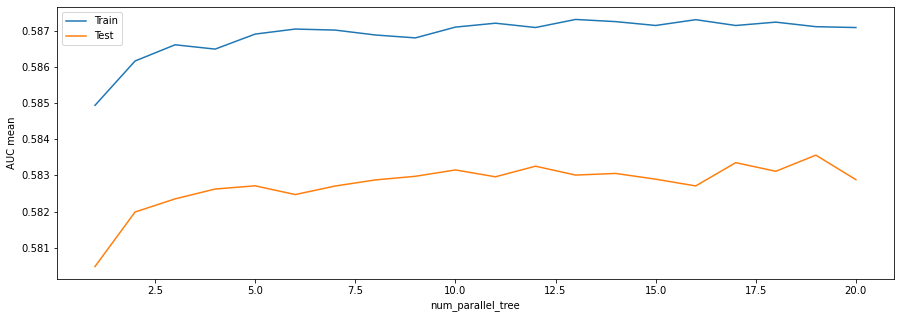

In [61]:
params = {'objective':'binary:logistic',
          'num_parallel_tree':3,
          'eval_metric':'auc',
          'min_child_weight':500,
          'max_depth':1,
          'subsample':0.7,
          'seed':42}

param_grid = pd.DataFrame({'num_parallel_tree':np.arange(1,21)})
param_grid[['train-auc-mean','train-auc-std','test-auc-mean','test-auc-std']] = param_grid.apply(fit,axis=1,result_type='expand',params=params, target='num_parallel_tree')

fig, ax = plt.subplots(figsize=(15,5))
param_grid.plot(x='num_parallel_tree',y='train-auc-mean', ax=ax, label='Train')
param_grid.plot(x='num_parallel_tree',y='test-auc-mean', ax=ax, label='Test')
ax.set_ylabel('AUC mean')

We observe an increase in the test metric until around 8 trees, where the AUC starts to stabilize. 

Now, *eta*:

Text(0, 0.5, 'AUC mean')

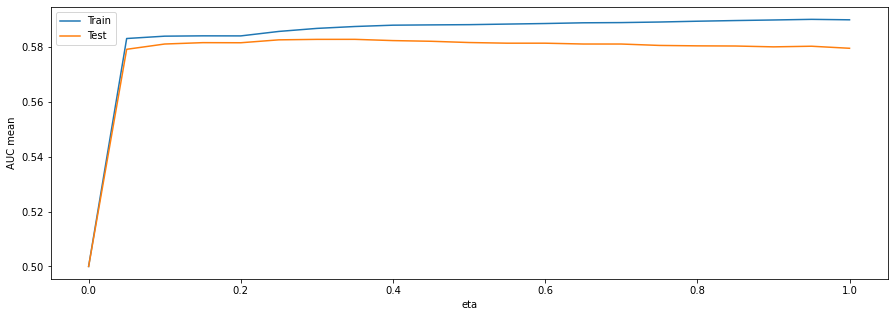

In [63]:
params = {'objective':'binary:logistic',
          'num_parallel_tree':8,
          'eval_metric':'auc',
          'min_child_weight':500,
          'max_depth':1,
          'subsample':0.7,
          'seed':42}

param_grid = pd.DataFrame({'eta':np.linspace(0,1,21)})
param_grid[['train-auc-mean','train-auc-std','test-auc-mean','test-auc-std']] = param_grid.apply(fit,axis=1,result_type='expand',params=params, target='eta')

fig, ax = plt.subplots(figsize=(15,5))
param_grid.plot(x='eta',y='train-auc-mean', ax=ax, label='Train')
param_grid.plot(x='eta',y='test-auc-mean', ax=ax, label='Test')
ax.set_ylabel('AUC mean')

The result is similar to the one we obtained with *max_depth*. The optimal value sits between 0.1 and 0.2. We will select the upper bound, which is closer to the default (0.3).

Finally, the last parameter is *subsample*:

Text(0, 0.5, 'AUC mean')

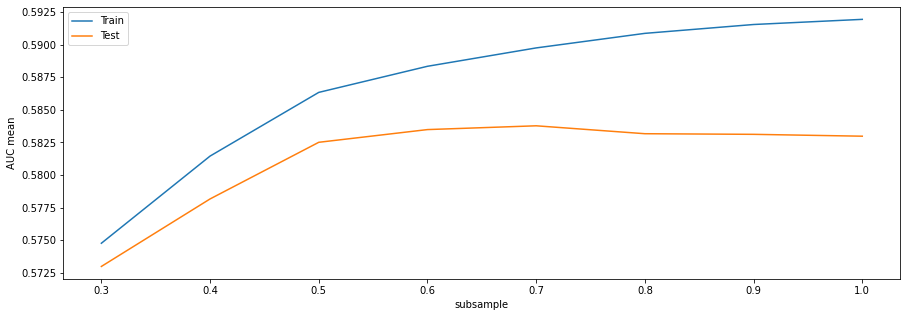

In [64]:
params = {'objective':'binary:logistic',
          'num_parallel_tree':8,
          'eval_metric':'auc',
          'min_child_weight':500,
          'max_depth':3,
          'eta':0.2,
          'subsample':0.7,
          'seed':42}

param_grid = pd.DataFrame({'subsample':np.linspace(0.3,1,8)})
param_grid[['train-auc-mean','train-auc-std','test-auc-mean','test-auc-std']] = param_grid.apply(fit,axis=1,result_type='expand',params=params, target='subsample')

fig, ax = plt.subplots(figsize=(15,5))
param_grid.plot(x='subsample',y='train-auc-mean', ax=ax, label='Train')
param_grid.plot(x='subsample',y='test-auc-mean', ax=ax, label='Test')
ax.set_ylabel('AUC mean')

We can find the optimal value between 0.6 and 0.7. We will select the lower bound which shows less overfit.

After completing HPO we will train the model with the resulting parameters and apply it to the test set we partitioned at the beginning:

In [65]:
test_X_sel = test_X[['attribute_0','attribute_1']+selected_features+tentative_features].copy()
test_X_sel_num = cat_to_num(test_X_sel)
dtest_X = xgb.DMatrix(test_X_sel_num, label=test_y)

c:\Users\gabri\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [66]:
params = {'subsample':0.6, 'num_parallel_tree':8, 'objective':'binary:logistic', 'eval_metric':'auc', 'seed':42,
          'min_child_weight':500, 'max_depth':3, 'eta':0.2}

model = xgb.train(params, dtrain_X, evals=[(dtest_X, 'test')], num_boost_round=100, early_stopping_rounds=5)

[0]	test-auc:0.60158
[1]	test-auc:0.60119
[2]	test-auc:0.60202
[3]	test-auc:0.60259
[4]	test-auc:0.60378
[5]	test-auc:0.60271
[6]	test-auc:0.60238
[7]	test-auc:0.60346
[8]	test-auc:0.60450
[9]	test-auc:0.60533
[10]	test-auc:0.60537
[11]	test-auc:0.60604
[12]	test-auc:0.60655
[13]	test-auc:0.60669
[14]	test-auc:0.60686
[15]	test-auc:0.60717
[16]	test-auc:0.60720
[17]	test-auc:0.60765
[18]	test-auc:0.60752
[19]	test-auc:0.60788
[20]	test-auc:0.60790
[21]	test-auc:0.60772
[22]	test-auc:0.60779
[23]	test-auc:0.60749
[24]	test-auc:0.60727


In [67]:
pred = model.predict(dtest_X)
pred_bool = np.where(pred < 0.5, 0, 1)

In [69]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(test_y, pred_bool))
print('ROC AUC score: ', roc_auc_score(test_y, pred_bool))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4097
           1       0.00      0.00      0.00      1217

    accuracy                           0.77      5314
   macro avg       0.39      0.50      0.44      5314
weighted avg       0.59      0.77      0.67      5314

ROC AUC score:  0.5


c:\Users\gabri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gabri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The obtained AUC score is 0.5, which is considerably lower than the obtained score in the validation set (0.60727). In any case, let's apply it to the Kaggle test set to obtain the true score.

## Test prediction and submission

In [71]:
test = pd.read_csv('data/test.csv')
test_sel = test[['attribute_0','attribute_1']+selected_features+tentative_features].copy()
test_sel_num = cat_to_num(test_sel)
dtest = xgb.DMatrix(test_sel_num, label=None)

c:\Users\gabri\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [72]:
test_pred = model.predict(dtest)

In [60]:
submission = pd.DataFrame({'id':test.id, 'failure':test_pred})
submission.to_csv('submission.csv', index=False)

The final score obtained is 0.58891, which is closer to the score obtained in validation. For reference, the highest score obtained in the competition is 0.59128 and the score we obtained sits in the top 25%. This is nothing spectacular of course, but for a quick solution based on one of the most popular tools in xgboost, it is satisfactory.